In [1]:
import pickle
with open('/kaggle/input/thyroid-mask-model/Thyroid_Model (1).pkl', 'rb') as file:  
    model = pickle.load(file)

model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

In [3]:
import pandas as pd
import os
import shutil  # For copying files from /kaggle/input to /kaggle/working

paths = []
for dirname, _, filenames in os.walk("/kaggle/input/test-4"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

# Split all paths by extension
masks = []
for path in paths:
    if path.split('.')[-1] == "PNG":
       masks.append(Image.open(path))

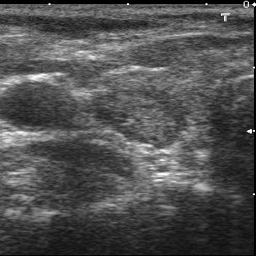

In [4]:
masks[0]

In [5]:
mks=[]
for y in masks:
    mks.append(img_to_array(y));

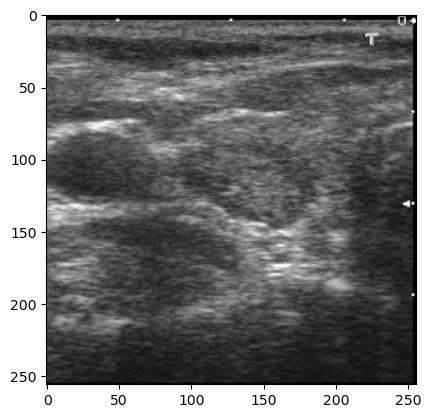

In [6]:
plt.imshow(mks[0],cmap="gray")

In [7]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

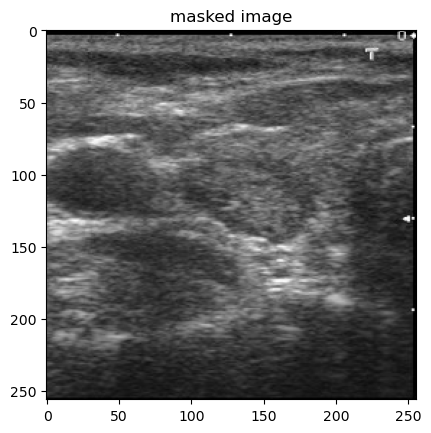

In [8]:
B=[]
for j in mks:
    B.append(convertToThreeChannel(j))
plt.figure
plt.imshow(B[0])
plt.title("masked image")
plt.show()

In [9]:
mask=[]

In [10]:
print(B[0])

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  5   5   5]
  [  1   1   1]
  [  2   2   2]]

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [  5   5   5]
  [  0   0   0]
  [  1   1   1]]

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [  6   6   6]
  [126 126 126]
  [  0   0   0]]

 ...

 [[ 57  57  57]
  [ 50  50  50]
  [ 41  41  41]
  ...
  [ 20  20  20]
  [  2   2   2]
  [  0   0   0]]

 [[ 38  38  38]
  [ 38  38  38]
  [ 38  38  38]
  ...
  [ 17  17  17]
  [  0   0   0]
  [  9   9   9]]

 [[  3   3   3]
  [  4   4   4]
  [  5   5   5]
  ...
  [  7   7   7]
  [  2   2   2]
  [  2   2   2]]]


In [11]:
for j in B:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [12]:
mask=np.array(mask)
print(mask.shape)

(5, 256, 256, 3)


In [13]:
mask=mask/255

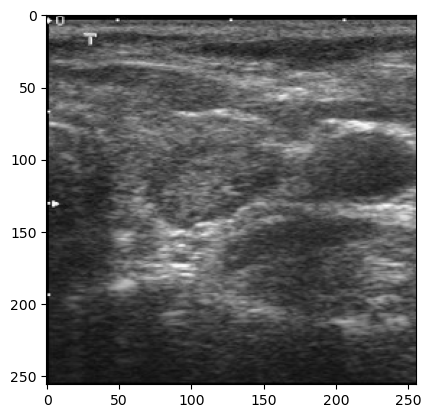

In [14]:
plt.imshow(mask[0])

In [15]:
test_img_input=np.expand_dims(mask[0], 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

1/1 [==============================] - 2s 2s/step
(256, 256)


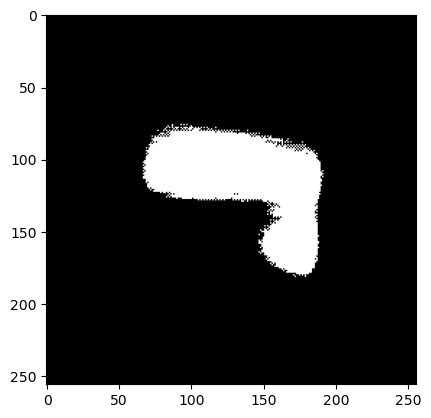

In [16]:
plt.imshow(prediction,cmap="gray")

In [17]:
import random
import skimage.io
import skimage.filters
import skimage.measure

In [18]:
image_gray = skimage.color.rgb2gray(mask[0])
thresh = skimage.filters.threshold_otsu(prediction)
tumor_mask = image_gray > thresh
# Measure the size of the tumor in pixels and convert to millimeters
pixel_size = 0.1  # the size of a pixel in millimeters
label_image = skimage.measure.label(tumor_mask)
region_props = skimage.measure.regionprops(label_image)
if len(region_props) == 0:
    tumor_size_mm = 0.0
else:
    tumor_area = region_props[0].area
    tumor_size_mm = tumor_area * pixel_size ** 2
print(f"The size of the tumor is {tumor_size_mm:.2f} mm^2")

The size of the tumor is 647.94 mm^2
